In [1]:
from dataloader import RetinopathyDataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models
from torchvision import transforms
import pyprind

In [2]:
from IPython.display import clear_output

In [3]:
train_dataset = RetinopathyDataset('./data', 'train')
test_dataset = RetinopathyDataset('./data', 'test')

augmentation = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
]
train_dataset_with_augementation = RetinopathyDataset('./data', 'train', augmentation=augmentation)

> Found 28099 images...
> Found 7025 images...
> Found 28099 images...


In [4]:
class BasicBlock(nn.Module):
    '''
    x = (in, H, W) -> conv2d -> (out, H, W) -> conv2d -> (out, H, W) + x
    '''
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, downsample=None):
        super(BasicBlock, self).__init__()
        padding = int(kernel_size/2)
        self.activation = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 
                kernel_size=kernel_size, padding=padding, stride=stride, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(
                out_channels, out_channels, 
                kernel_size=kernel_size, padding=padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.activation(out)
        
        return out

class BottleneckBlock(nn.Module):
    '''
    x = (in, H, W) -> conv2d(1x1) -> conv2d -> (out, H, W) -> conv2d(1x1) -> (out*4, H, W) + x 
    '''
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, downsample=None):
        super(BottleneckBlock, self).__init__()
        padding = int(kernel_size/2)
        self.activation = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(
                out_channels, out_channels,
                kernel_size=kernel_size, stride=stride, padding=padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion),
        )
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.block(x)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.activation(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, start_in_channels=64):
        super(ResNet, self).__init__()
        
        self.current_in_channels = start_in_channels
        
        self.first = nn.Sequential(
            nn.Conv2d(
                3, self.current_in_channels,
                kernel_size=7, stride=2, padding=3, bias=False
            ),
            nn.BatchNorm2d(self.current_in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.layers = layers
        channels = self.current_in_channels
        for i, l in enumerate(layers):
            setattr(self, 'layer'+str(i+1), 
                    self._make_layer(block, channels, l, stride=(2 if i!=0 else 1) ))
            channels*=2
        
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.current_in_channels, num_classes)
            
    def _make_layer(self, block, in_channels, blocks, stride=1):
        downsample=None
        if stride != 1 or self.current_in_channels != in_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.current_in_channels, in_channels * block.expansion,
                    kernel_size = 1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(in_channels * block.expansion)
            )
        
        layers = []
        layers.append(block(self.current_in_channels, in_channels, stride=stride, downsample=downsample))
        self.current_in_channels = in_channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.current_in_channels, in_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.first(x)
        #print(x.shape)
        for i in range(len(self.layers)):
            x = getattr(self, 'layer'+str(i+1))(x)
            #print(x.shape)
        x = self.avgpool(x)
        # flatten
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [5]:
class PretrainResNet(nn.Module):
    def __init__(self, num_classes, num_layers):
        super(PretrainResNet, self).__init__()
        
        pretrained_model = torchvision.models.__dict__[
            'resnet{}'.format(num_layers)](pretrained=True)
        
        self.conv1 = pretrained_model._modules['conv1']
        self.bn1 = pretrained_model._modules['bn1']
        self.relu = pretrained_model._modules['relu']
        self.maxpool = pretrained_model._modules['maxpool']

        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(
            pretrained_model._modules['fc'].in_features, num_classes
        )
                
        del pretrained_model
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [6]:
def ResNet18(pre_train=False):
    if pre_train:
        return PretrainResNet(num_classes=5, num_layers=18)
    return ResNet(BasicBlock, layers=[2,2,2,2], num_classes=5)
def ResNet50(pre_train=False):
    if pre_train:
        return PretrainResNet(num_classes=5, num_layers=50)
    return ResNet(BottleneckBlock, layers=[3,4,6,3], num_classes=5)

In [7]:
def showAccuracy(title='', accline=[75, 82], **kwargs):
    fig = plt.figure(figsize=(8,4.5))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    
    for label, data in kwargs.items():
        plt.plot(
            range(1, len(data)+1), data, 
            '--' if 'test' in label else '-', 
            label=label
        )
    
    plt.legend(
        loc='best', bbox_to_anchor=(1.0, 1.0, 0.2, 0),
        fancybox=True, shadow=True
    )
    
    if accline:
        plt.hlines(accline, 1, len(data)+1, linestyles='dashed', colors=(0,0,0,0.8))
    
    plt.show()
    
    return fig

In [8]:
def evalModels(models, test_loader, testing_mode=False):
    test_correct = {key:0.0 for key in models}
    bar = pyprind.ProgPercent(len(test_loader.dataset), title="Testing epoch : ")
    for model in models.values():
        model.train(testing_mode)
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            x, y = data
            inputs = x.to(device)
            labels = y.to(device)
        
            for key, model in models.items():
                outputs = model(inputs)
        
                test_correct[key] += (
                    torch.max(outputs, 1)[1] == labels.long().view(-1)
                ).sum().item()
            
            bar.update(test_loader.batch_size)
            #clear_output(wait=True)
            #print('Testing batch : {:.3f} %'.format(
            #    ((idx+1)*test_loader.batch_size*100) / len(test_loader.dataset)
            #))
        
    return test_correct

In [9]:
def runModels(
    name, train_dataset, test_dataset, models, epoch_size, batch_size, learning_rate, 
    optimizer = optim.SGD, optimizer_option = {'momentum':0.9, 'weight_decay':5e-4}, 
    criterion = nn.CrossEntropyLoss(),
    show = True, testing_mode=False
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    accs, pre_epoch = load_running_state(name, models)
    
    if accs is None:
        accs = {
            **{key+"_train" : [] for key in models},
            **{key+"_test" : [] for key in models}
        }
    if pre_epoch is None:
        pre_epoch = 0
    else:
        pre_epoch += 1
    
    if show:
        showAccuracy(
            title='Epoch [{:4d}]'.format(pre_epoch),
            **accs
        )
    
    optimizers = {
        key: optimizer(value.parameters(), lr=learning_rate, **optimizer_option) 
        for key, value in models.items()
    }
    for epoch in range(pre_epoch, epoch_size):
        bar = pyprind.ProgPercent(len(train_dataset), title="Training epoch {} : ".format(epoch+1))
        
        train_correct = {key:0.0 for key in models}
        test_correct = {key:0.0 for key in models}
        # training multiple model
        for model in models.values():
            model.train()
        
        for idx, data in enumerate(train_loader):
            x, y = data
            inputs = x.to(device)
            labels = y.to(device).long().view(-1)
        
            for optimizer in optimizers.values():
                optimizer.zero_grad()
        
            for key, model in models.items():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                cur_correct = (
                    torch.max(outputs, 1)[1] == labels
                ).sum().item()
            
                train_correct[key] += cur_correct
        
            for optimizer in optimizers.values():
                optimizer.step()
            
            bar.update(batch_size)
            #clear_output(wait=True)
            #print('Training batch : {:.3f} %'.format(((idx+1)*batch_size*100) / len(train_dataset)))
        
        # testing multiple model
        test_correct = evalModels(
            models, test_loader, 
            testing_mode=testing_mode
        )

        for key, value in train_correct.items():
            accs[key+"_train"] += [(value*100.0) / len(train_dataset)]
    
        for key, value in test_correct.items():
            accs[key+"_test"] += [(value*100.0) / len(test_dataset)]
         
        if show:
            clear_output(wait=True)
            showAccuracy(
                title='Epoch [{:4d}]'.format(epoch + 1),
                **accs
            )
        
        # epoch end
        torch.cuda.empty_cache()
        save_running_state(name, models, accs, epoch)
    
    return accs
Accs = {}

In [10]:
def save_running_state(name, models, accs, epoch, root='./result'):
    if not os.path.isdir(root):
        os.mkdir(root)
    root = os.path.join(root, name)
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, 'state.pkl')
    save_model(models, root)
    
    state = {'accs' : accs, 'epoch':epoch }
    torch.save(state, p)
        
        
def load_running_state(name, models, root='./result'):
    root = os.path.join(root, name)
    p = os.path.join(root, 'state.pkl')
    if not os.path.isfile(p):
        return None, None
    
    load_model(models, root)
    
    state = torch.load(p)
    accs = state['accs']
    epoch = state['epoch']
    return accs, epoch

In [11]:
def __save_model(model_name, model, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    torch.save(model.state_dict(), p)
    return p

def save_model(models, root='./model'):
    p = {}
    for k, m in models.items():
        p[k] = __save_model(k, m, root)
    return p

def __load_model(model_name, model, root):
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    if not os.path.isfile(p):
        raise AttributeError(
            "No model parameters file for {}!".format(model_name)
        )
    paras = torch.load(p)
    model.load_state_dict(paras)

def load_model(models, root='./model'):
    for k, m in models.items():
        __load_model(k, m, root)
        
def save_image(fig, title, root):
    fig.savefig(
        fname=os.path.join(root, title + '.png'),
        dpi=300,
        metadata = {
            'Title': title,
            'Author': '0756110',
        },
        bbox_inches="tight",
    )
    
def save_accuracy(name, models, accs, root='./result'):
    if not os.path.isdir(root):
        os.mkdir(root)
    root = os.path.join(root, name)
    if not os.path.isdir(root):
        os.mkdir(root)
    fig = showAccuracy(
        title=name,
        **accs
    )
    save_image(fig, title=name, root=root)
    p = os.path.join(root, name+'_accuracy.pkl')
    torch.save(accs, p)

In [12]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet18" : ResNet18().to(device),
    "ResNet18(pretrain)": ResNet18(pre_train=True).to(device),
}

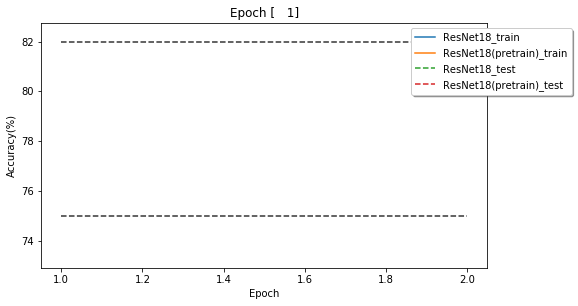

Training epoch 2 : 
[  8 %] Time elapsed: 00:02:07 | ETA: 00:21:53

In [ ]:
%%time
# Training & Testing
name = 'ResNet18'
Accs[name] = runModels(
    name, train_dataset, test_dataset, models,
    epoch_size=10, batch_size=4, learning_rate=1e-3, show=True)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [16]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet18" : ResNet18().to(device),
    "ResNet18(pretrain)": ResNet18(pre_train=True).to(device),
}

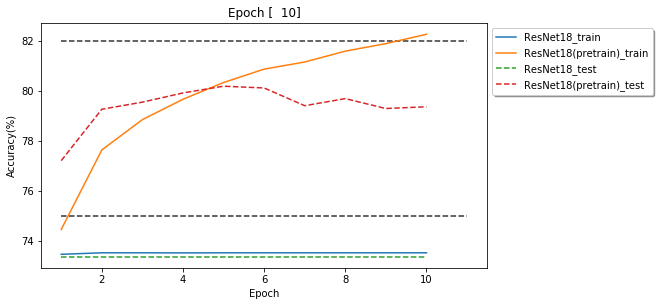

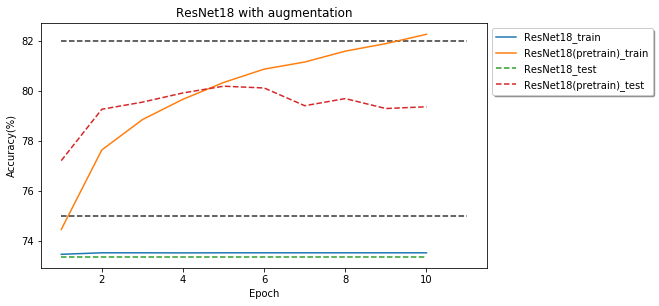

CPU times: user 450 ms, sys: 69.2 ms, total: 519 ms
Wall time: 519 ms


In [34]:
%%time
# Training & Testing
name = 'ResNet18 with augmentation'
Accs[name] = runModels(
    name, train_dataset_with_augementation, test_dataset, models, 
    epoch_size=10, batch_size=4, learning_rate=1e-3, show=True)
fig = showAccuracy(
    title=name,
    **Accs[name]
)

In [98]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "ResNet50" : ResNet50().to(device),
    "ResNet50(pretrain)": ResNet50(pre_train=True).to(device),
}

In [ ]:
%%time
# Training & Testing
name = 'ResNet50'
Accs[name] = runModels(models, epoch_size=5, batch_size=4, learning_rate=1e-3, show=True)
fig = showAccuracy(
    title=name,
    **Accs[name]
)
save_accuracy(name, Accs[name])